In [1]:
import pyaudio
import wave
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2024-06-30 16:32:14.135905: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-30 16:32:14.329832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 16:32:14.329870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 16:32:14.361754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-30 16:32:14.429879: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def record_audio(filename, duration, channels=1, rate=44100, chunk=1024):
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16,
                    channels=channels,
                    rate=rate,
                    input=True,
                    frames_per_buffer=chunk)
    print(f"Recording {filename}...")
    frames = []

    for _ in range(0, int(rate / chunk * duration)):
        data = stream.read(chunk)
        frames.append(data)

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(filename, 'wb')
    wf.setnchannels(channels)
    wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
    wf.setframerate(rate)
    wf.writeframes(b''.join(frames))
    wf.close()
    print(f"Saved {filename}")


In [16]:
def record_wake_word(directory, num_samples, duration=1):
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i in range(num_samples):
        filename = os.path.join(directory, f"wake_word_{i+1}.wav")
        record_audio(filename, duration)

# Example usage:
record_wake_word("wake_words", num_samples=100, duration=2)

Recording wake_words/wake_word_1.wav...
Saved wake_words/wake_word_1.wav
Recording wake_words/wake_word_2.wav...
Saved wake_words/wake_word_2.wav
Recording wake_words/wake_word_3.wav...
Saved wake_words/wake_word_3.wav
Recording wake_words/wake_word_4.wav...
Saved wake_words/wake_word_4.wav
Recording wake_words/wake_word_5.wav...
Saved wake_words/wake_word_5.wav
Recording wake_words/wake_word_6.wav...
Saved wake_words/wake_word_6.wav
Recording wake_words/wake_word_7.wav...
Saved wake_words/wake_word_7.wav
Recording wake_words/wake_word_8.wav...
Saved wake_words/wake_word_8.wav
Recording wake_words/wake_word_9.wav...
Saved wake_words/wake_word_9.wav
Recording wake_words/wake_word_10.wav...
Saved wake_words/wake_word_10.wav
Recording wake_words/wake_word_11.wav...
Saved wake_words/wake_word_11.wav
Recording wake_words/wake_word_12.wav...
Saved wake_words/wake_word_12.wav
Recording wake_words/wake_word_13.wav...
Saved wake_words/wake_word_13.wav
Recording wake_words/wake_word_14.wav...
Sa

In [13]:
def record_background_sound(directory, num_samples, duration=1):
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i in range(num_samples):
        filename = os.path.join(directory, f"background_sound_{i+1}.wav")
        record_audio(filename, duration)

# Example usage:
record_background_sound("background_sounds", num_samples=100, duration=2)

Recording background_sounds/background_sound_1.wav...
Saved background_sounds/background_sound_1.wav
Recording background_sounds/background_sound_2.wav...
Saved background_sounds/background_sound_2.wav
Recording background_sounds/background_sound_3.wav...
Saved background_sounds/background_sound_3.wav
Recording background_sounds/background_sound_4.wav...
Saved background_sounds/background_sound_4.wav
Recording background_sounds/background_sound_5.wav...
Saved background_sounds/background_sound_5.wav
Recording background_sounds/background_sound_6.wav...
Saved background_sounds/background_sound_6.wav
Recording background_sounds/background_sound_7.wav...
Saved background_sounds/background_sound_7.wav
Recording background_sounds/background_sound_8.wav...
Saved background_sounds/background_sound_8.wav
Recording background_sounds/background_sound_9.wav...
Saved background_sounds/background_sound_9.wav
Recording background_sounds/background_sound_10.wav...
Saved background_sounds/background_s

In [31]:
def remove_silence(y, sr, top_db=20):
    # Trim silence from the beginning and end
    y_trimmed, _ = librosa.effects.trim(y, top_db=top_db)
    return y_trimmed

In [32]:
def extract_mel_spectrogram(file_path, sr=22050, n_mels=128, hop_length=512, top_db = 20, max_length=120):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=sr)
    #remove silence
    y_no_silence = remove_silence(y, sr, top_db=top_db)
    # Normalize the audio
    y_normalized = librosa.util.normalize(y_no_silence)
    # Extract mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y_normalized, sr=sr, n_mels=n_mels, hop_length=hop_length)
    # Convert to log scale (dB)
    mfcc = librosa.power_to_db(mel_spectrogram, ref=np.max)
    #normalize
    mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
    # Pad or truncate the MFCC features to ensure uniform input size
    if mfcc.shape[1] < max_length:
        pad_width = max_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    
    return mfcc

In [33]:
def convert(wake_dir = './wake_words'):
    files = os.listdir(wake_dir)
    arr = []
    for file in files:
        file = wake_dir + '/' + file
        spec = extract_mel_spectrogram(file)
        arr.append(spec)
    return np.array(arr)

wake = convert()

In [34]:
back = convert('./background_sounds')

In [35]:
y = np.array([1] * 100 + [0] * 100)

In [36]:
X = np.concatenate([wake, back], axis = 0)
X = np.expand_dims(X, axis=-1)

In [37]:
def time_shift_spectrogram(spectrogram, y, shift_max, shift_direction='both'):
    num_cols = spectrogram.shape[1]
    shift = np.random.randint(shift_max)
    if shift_direction == 'right':
        shift = shift
    elif shift_direction == 'left':
        shift = -shift
    elif shift_direction == 'both':
        shift = np.random.choice([-shift, shift])
    return np.roll(spectrogram, shift, axis=1), y

def frequency_shift_spectrogram(spectrogram, y, shift_max):
    num_rows = spectrogram.shape[0]
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(spectrogram, shift, axis=0), y

def add_noise(spectrogram, y, noise_factor):
    noise = np.random.randn(*spectrogram.shape)
    augmented_spectrogram = spectrogram + noise_factor * noise
    return augmented_spectrogram, y

def augment_spectrogram(spectrogram, y, noise_factor = 1e-7, shift_max=2):
    spectrogram = np.concatenate([spectrogram, time_shift_spectrogram(spectrogram, y, shift_max)[0]], axis = 0)
    y = np.concatenate([y, y], axis=0)
    spectrogram = np.concatenate([spectrogram, frequency_shift_spectrogram(spectrogram, y, shift_max)[0]], axis = 0)
    y = np.concatenate([y, y], axis=0)
    spectrogram = np.concatenate([spectrogram, add_noise(spectrogram, y, noise_factor)[0]], axis = 0)   
    y = np.concatenate([y, y], axis=0)
    return spectrogram, y

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

In [39]:
X_train, y_train = augment_spectrogram(spectrogram = X_train, y = y_train)

In [40]:
model = Sequential()

# First Convolutional Layer
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 87, 1)))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2, 2)))

# Second Convolutional Layer
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third Convolutional Layer
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flattening
model.add(BatchNormalization())
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the Model
checkpoint_path = 'best_model.h5'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [41]:
history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/20


2024-06-30 16:46:45.987029: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


126/128 [============================>.] - ETA: 0s - loss: 1.5290 - accuracy: 0.5694
Epoch 1: val_accuracy improved from -inf to 0.78125, saving model to best_model.h5
128/128 [==============================] - 2s 7ms/step - loss: 1.5147 - accuracy: 0.5723 - val_loss: 0.6833 - val_accuracy: 0.7812
Epoch 2/20
121/128 [===========================>..] - ETA: 0s - loss: 0.6921 - accuracy: 0.5630
Epoch 2: val_accuracy did not improve from 0.78125
128/128 [==============================] - 1s 5ms/step - loss: 0.6922 - accuracy: 0.5576 - val_loss: 0.6839 - val_accuracy: 0.7188
Epoch 3/20
123/128 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5254
Epoch 3: val_accuracy did not improve from 0.78125
128/128 [==============================] - 1s 5ms/step - loss: 0.6821 - accuracy: 0.5283 - val_loss: 0.7824 - val_accuracy: 0.3438
Epoch 4/20
128/128 [==============================] - ETA: 0s - loss: 0.6716 - accuracy: 0.5947
Epoch 4: val_accuracy did not improve from 0.7812

In [42]:
best_model = tf.keras.models.load_model(checkpoint_path)
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
y_pred = best_model.predict(X_test) 
y_pred = np.where(y_pred < 0.5, 0, 1)
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matix:\n', cm)

2/2 [==============================] - 0s 3ms/step - loss: 0.6011 - accuracy: 0.9500
Test Loss: 0.6010547280311584
Test Accuracy: 0.949999988079071
2/2 [==============================] - 0s 4ms/step
Confusion Matix:
 [[18  0]
 [ 2 20]]


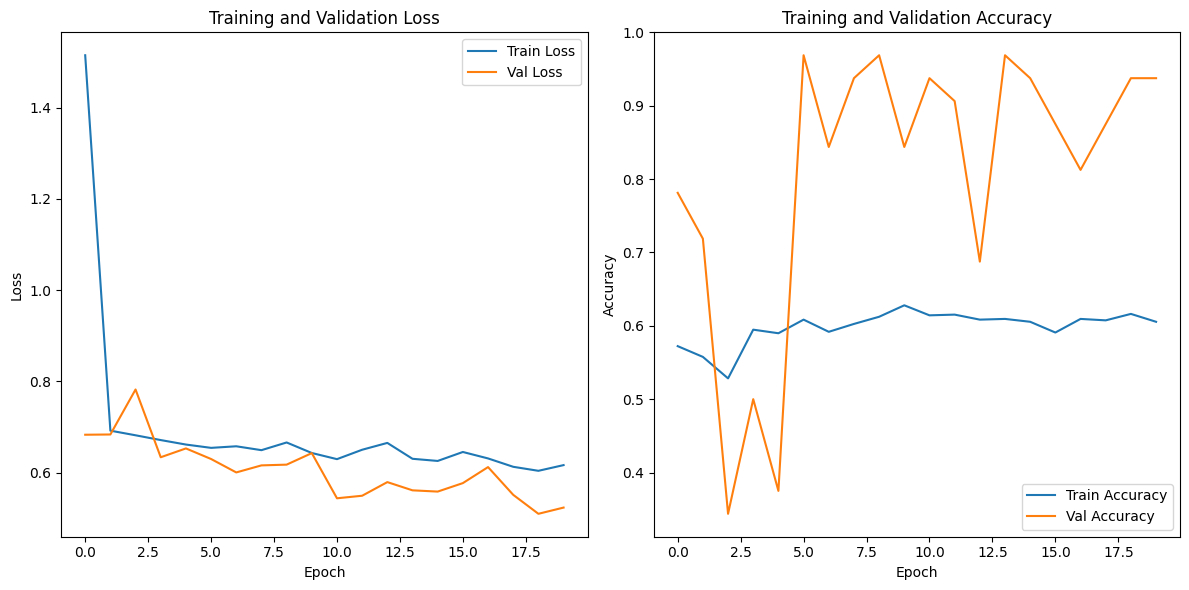

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training history: accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('result')
plt.show()